In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from tqdm import tqdm
from sklearn.utils import check_random_state

from dataset import SyntheticSlateBanditDataset
from policy import gen_eps_greedy
from estimator import SlateInversePropensityScore as IPS
from util import SlateOffPolicyEvaluation, aggregate_simulation_results, visualize_mean_squared_error

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
# setting 2

# 変数
p_list=[0., .3, .7, 1.0]
behavior_ratio = lambda p: {"independent": (1.0 - p), "cascade": p/2, "all": p/2}

# 定数
test_size=10000
val_size=500
n_sim=30
dim_context=5
n_actions=3
len_list=3
alpha = np.ones(len_list)
eps=0.5
return_pscore={"all": True, "independent": True, "cascade": False, "adaptive": False}
estimator_to_pscore_dict={"SIPS": "all", "IIPS": "independent"}

In [9]:
# experiment-1 varying independent behavior ratio

test_return_pscore={"all": False, "independent": False, "cascade": False, "adaptive": False}

result_df_list = []
for p in p_list:

    dataset = SyntheticSlateBanditDataset(
        n_unique_action=n_actions,
        len_list=len_list,
        dim_context=dim_context,
        behavior_ratio=behavior_ratio(p),
    )
    # calculate ground truth policy value
    test_data = dataset.obtain_batch_bandit_feedback(n_rounds=test_size, return_pscore=test_return_pscore)

    expected_reward_factual = test_data["expected_reward"][np.arange(test_size),test_data["user_behavior_id"]]
    policy_value = dataset.calc_ground_truth_policy_value(
        user_behavior_prob=np.array(list(behavior_ratio(p).values())),
        expected_reward=test_data['expected_reward'],
        evaluation_policy=gen_eps_greedy(expected_reward=expected_reward_factual, eps=eps),
        alpha=alpha
    )

    
    result_list = []
    for seed in tqdm(range(n_sim), desc=f"p={p}..."):
        
        # generate synthetic data
        dataset = SyntheticSlateBanditDataset(
            n_unique_action=n_actions,
            len_list=len_list,
            dim_context=dim_context,
            behavior_ratio=behavior_ratio(p),
            random_state=seed,
        )
        val_data = dataset.obtain_batch_bandit_feedback(n_rounds=val_size, return_pscore=return_pscore)
        expected_reward_factual = val_data["expected_reward"][np.arange(val_size), val_data["user_behavior_id"]]
        
        # evaluation policy
        evaluation_policy = gen_eps_greedy(expected_reward=expected_reward_factual, eps=eps)
        _, evaluation_policy_pscore = dataset.aggregate_propensity_score(
            ranking_pi=evaluation_policy, 
            slate_id=val_data["slate_id"],
            user_behavior=val_data["user_behavior"],
            return_pscore=return_pscore
        )
        
        # off policy evaluation
        ope_estimators = [IPS(estimator_name=estimator_name) for estimator_name, _ in estimator_to_pscore_dict.items()]
        ope = SlateOffPolicyEvaluation(
            bandit_feedback=val_data,
            ope_estimators=ope_estimators,
            estimator_to_pscore_dict=estimator_to_pscore_dict
        )
        estimated_policy_values = ope.estimate_policy_values(
            alpha=alpha, 
            evaluation_policy_pscore=evaluation_policy_pscore
        )
        
        result_list.append(estimated_policy_values)
    
    # calculate MSE
    result_df = aggregate_simulation_results(
        simulation_result_list=result_list,
        policy_value=policy_value,
        x_value=p
    )
    result_df_list.append(result_df)
        
result_df = pd.concat(result_df_list).reset_index(level=0)

p=0.0...: 100% 30/30 [01:02<00:00,  2.07s/it]
p=0.3...: 100% 30/30 [01:02<00:00,  2.09s/it]
p=0.7...: 100% 30/30 [01:03<00:00,  2.12s/it]
p=1.0...: 100% 30/30 [01:02<00:00,  2.07s/it]


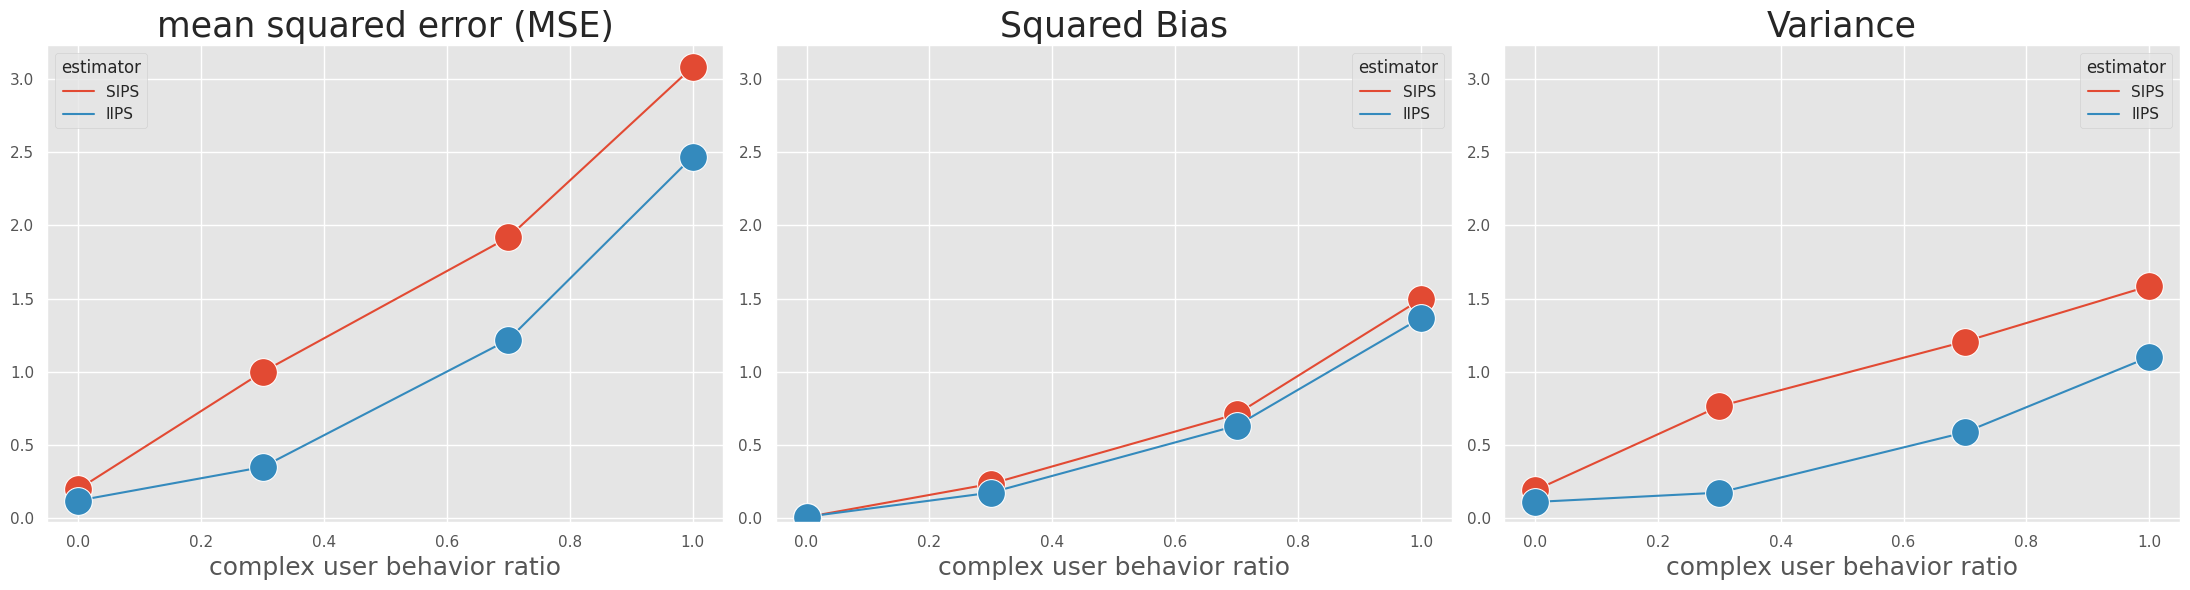

In [10]:
visualize_mean_squared_error(result_df=result_df, xlabel="complex user behavior ratio")

In [14]:
r = np.random.uniform(0,1,size=(100,))
check_random_state(0).normal(r, scale=1.)

array([ 2.41912585e+00,  6.22428026e-01,  1.70673685e+00,  2.82437380e+00,
        2.46934670e+00,  1.20449861e-02,  1.54699615e+00,  4.33500558e-01,
       -9.50809671e-02,  8.81822486e-01,  3.05960577e-01,  1.69754358e+00,
        1.07289443e+00,  3.79198495e-01,  1.00772991e+00,  7.38911573e-01,
        2.14979360e+00,  4.73469192e-01,  7.79814594e-01, -6.32451782e-01,
       -2.45481870e+00,  9.24835819e-01,  1.65369470e+00,  1.85029173e-01,
        2.88827419e+00, -1.17588179e+00,  7.01232764e-01,  4.49416776e-01,
        2.45495407e+00,  1.67667865e+00,  8.21535732e-01,  3.93213481e-01,
       -3.05431261e-01, -1.76200081e+00,  3.82404934e-01,  5.66650609e-01,
        1.33864794e+00,  1.30226519e+00, -2.82116788e-01,  2.63968648e-01,
       -6.16380323e-01, -5.03446812e-01, -1.58308201e+00,  2.21552486e+00,
       -3.32830718e-01,  4.85373919e-03, -7.92412635e-01,  1.35674908e+00,
       -8.34402046e-01, -8.54291660e-02,  1.33112305e-02,  1.32306696e+00,
        9.74082695e-04, -

In [ ]:
# setting 2

# 変数
p_list=[0., .2, .4, .6, .8, 1.0]
behavior_ratio = lambda p: {"independent": 0.0, "cascade": (1.0 - p), "all": p}

# 定数
test_size=10000
val_size=1000
n_sim=10
dim_context=5
n_actions=3
len_list=3
alpha = np.ones(len_list)
eps=0.5
return_pscore={"all": True, "independent": True, "cascade": True, "adaptive": False}
estimator_to_pscore_dict={"SIPS": "all", "IIPS": "independent", "RIPS": "cascade"}

In [ ]:
# experiment-1 varying independent behavior ratio

test_return_pscore={"all": False, "independent": False, "cascade": False, "adaptive": False}

result_df_list = []
for p in p_list:

    dataset = SyntheticSlateBanditDataset(
        n_unique_action=n_actions,
        len_list=len_list,
        dim_context=dim_context,
        behavior_ratio=behavior_ratio(p),
    )
    # calculate ground truth policy value
    test_data = dataset.obtain_batch_bandit_feedback(n_rounds=test_size, return_pscore=test_return_pscore)

    expected_reward_factual = test_data["expected_reward"][np.arange(test_size),test_data["user_behavior_id"]]
    policy_value = dataset.calc_ground_truth_policy_value(
        user_behavior_prob=np.array(list(behavior_ratio(p).values())),
        expected_reward=test_data['expected_reward'],
        evaluation_policy=gen_eps_greedy(expected_reward=expected_reward_factual, eps=eps),
        alpha=alpha
    )

    
    result_list = []
    for seed in tqdm(range(n_sim), desc=f"p={p}..."):
        
        # generate synthetic data
        dataset = SyntheticSlateBanditDataset(
            n_unique_action=n_actions,
            len_list=len_list,
            dim_context=dim_context,
            behavior_ratio=behavior_ratio(p),
            random_state=seed,
        )
        val_data = dataset.obtain_batch_bandit_feedback(n_rounds=val_size, return_pscore=return_pscore)
        expected_reward_factual = val_data["expected_reward"][np.arange(val_size), val_data["user_behavior_id"]]
        
        # evaluation policy
        evaluation_policy = gen_eps_greedy(expected_reward=expected_reward_factual, eps=eps)
        _, evaluation_policy_pscore = dataset.aggregate_propensity_score(
            ranking_pi=evaluation_policy, 
            slate_id=val_data["slate_id"],
            user_behavior=val_data["user_behavior"],
            return_pscore=return_pscore
        )
        
        # off policy evaluation
        ope_estimators = [IPS(estimator_name=estimator_name) for estimator_name, _ in estimator_to_pscore_dict.items()]
        ope = SlateOffPolicyEvaluation(
            bandit_feedback=val_data,
            ope_estimators=ope_estimators,
            estimator_to_pscore_dict=estimator_to_pscore_dict
        )
        estimated_policy_values = ope.estimate_policy_values(
            alpha=alpha, 
            evaluation_policy_pscore=evaluation_policy_pscore
        )
        
        result_list.append(estimated_policy_values)
    
    # calculate MSE
    result_df = aggregate_simulation_results(
        simulation_result_list=result_list,
        policy_value=policy_value,
        x_value=p
    )
    result_df_list.append(result_df)
        
result_df = pd.concat(result_df_list).reset_index(level=0)

In [ ]:
visualize_mean_squared_error(result_df=result_df, xlabel="complex user behavior ratio")